In [1]:
! pip install -q imagecodecs
! pip install -q warmup_scheduler
! pip install -q efficientnet_pytorch

In [2]:
from google.colab import drive 
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import warnings
warnings.filterwarnings("ignore")

# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from tqdm import tqdm
tqdm.pandas()

# Deep learning model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold

In [4]:
df_clean = pd.read_csv("drive/MyDrive/DLMI/train_clean.csv")
images_to_keep = df_clean[abs(df_clean["isup_grade"]-df_clean["out_of_fold_predictions"]) <= 1.5]["image_id"].values
print("{} images are kept".format(len(images_to_keep)))

286 images are kept


In [5]:
df = pd.read_csv("drive/MyDrive/DLMI/train_with_tiles.csv")
df = df[df["image_id"].isin(images_to_keep)].reset_index(drop=True)
df["tiles"] = df["tiles"].progress_apply(lambda x : np.array(x.replace("[", "").replace("]", "").split(",")).astype(np.int16).reshape(100, 128, 128, 3))

100%|██████████| 286/286 [11:39<00:00,  2.44s/it]


In [6]:
skf = StratifiedKFold(7, shuffle=True)
df["fold"] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df, df["isup_grade"])):
    df.loc[valid_idx, "fold"] = i

In [7]:
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_pretrained(backbone)

        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [8]:
class PANDADataset(Dataset):
    def __init__(self, df, image_size=128, n_tiles=100, transform=None,):
        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index, image_size=128):
        row = self.df.iloc[index]
        tiles = row.tiles
        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
                if len(tiles) > i:
                    this_img = tiles[i]
                else:
                    this_img = np.zeros((self.image_size, self.image_size, 3)).astype(np.uint8)
                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * image_size
                w1 = w * image_size
                images[h1:h1+image_size, w1:w1+image_size] = this_img
        if self.transform is not None:
            images = self.transform(image=images)['image']
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)
        label = row.isup_grade
        return torch.tensor(images), torch.tensor(label)

In [9]:
transforms_train = albumentations.Compose([albumentations.HorizontalFlip(p=0.5),
                                           albumentations.VerticalFlip(p=0.5),
                                           albumentations.Transpose(p=0.5)])

transforms_val = albumentations.Compose([])

In [10]:
dataset_show = PANDADataset(df, transform=transforms_train)

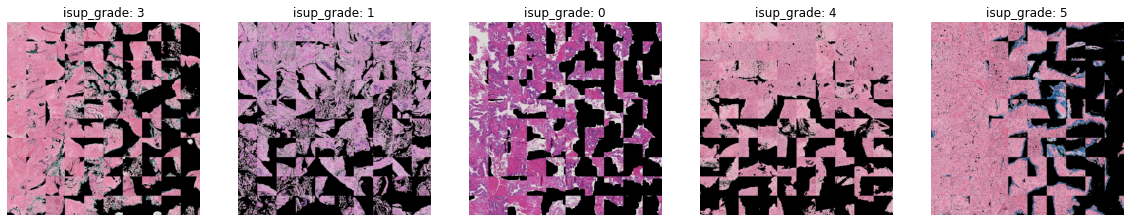

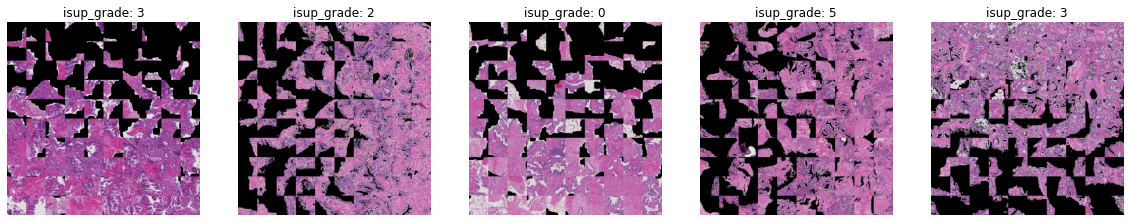

In [11]:
rcParams["figure.figsize"] = 20, 10
for i in range(2):
    f, axarr = plt.subplots(1, 5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title("isup_grade: "+str(label.numpy()))
        axarr[p].axis("off")

In [12]:
def train(num_epochs, batch_size, criterion, optimizer, model, df, fold):

    train_idx = np.where((df["fold"] != fold))[0]
    valid_idx = np.where((df["fold"] == fold))[0]

    dataset_train = PANDADataset(df.loc[train_idx], transform=transforms_train)
    dataset_valid = PANDADataset(df.loc[valid_idx], transform=transforms_val)

    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=4)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid), num_workers=4)

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs-1)
    scheduler = GradualWarmupScheduler(optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    val_loss_min = 1e20
        
    for epoch in range(1, num_epochs+1):
      
        model.train()
        train_loss = []
        for (data, target) in train_loader:
            data, target = data.to(device), target.to(device)
            loss_func = criterion
            optimizer.zero_grad()
            logits = model(data).view(-1)
            loss = loss_func(logits, target.float())
            loss.backward()
            optimizer.step()
            loss_np = loss.detach().cpu().numpy()
            train_loss.append(loss_np)
        train_loss = np.mean(train_loss)
        
        model.eval()
        val_loss = []
        with torch.no_grad():
            for (data, target) in valid_loader:
                data, target = data.to(device), target.to(device)
                logits = model(data).view(-1)
                loss = criterion(logits, target.float())
                val_loss.append(loss.detach().cpu().numpy())
            val_loss = np.mean(val_loss)
        
        scheduler.step()

        if val_loss < val_loss_min:
            print('Epoch [{}/{}], Valid loss ({:.4f} --> {:.4f}).  Saving model ...'.format(epoch, num_epochs, val_loss_min, val_loss))
            torch.save(model.state_dict(), "model.pth")
            val_loss_min = val_loss

In [13]:
device = torch.device("cuda")
num_epochs = 30
batch_size = 4
init_lr = 3e-4
criterion = nn.MSELoss()

In [14]:
model = enetv2("efficientnet-b0", out_dim=1)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=init_lr/10)

train(num_epochs, batch_size, criterion, optimizer, model, df, fold=0)

Loaded pretrained weights for efficientnet-b0
Epoch [1/30], Valid loss (100000000000000000000.0000 --> 3.8178).  Saving model ...
Epoch [2/30], Valid loss (3.8178 --> 2.4426).  Saving model ...
Epoch [4/30], Valid loss (2.4426 --> 1.3962).  Saving model ...
Epoch [5/30], Valid loss (1.3962 --> 1.1840).  Saving model ...
Epoch [6/30], Valid loss (1.1840 --> 1.0304).  Saving model ...
Epoch [9/30], Valid loss (1.0304 --> 0.8093).  Saving model ...
Epoch [14/30], Valid loss (0.8093 --> 0.8079).  Saving model ...
Epoch [15/30], Valid loss (0.8079 --> 0.6414).  Saving model ...
Epoch [16/30], Valid loss (0.6414 --> 0.6354).  Saving model ...
Epoch [19/30], Valid loss (0.6354 --> 0.5554).  Saving model ...
Epoch [20/30], Valid loss (0.5554 --> 0.4793).  Saving model ...


In [15]:
df_test = pd.read_csv("drive/MyDrive/DLMI/test_with_tiles.csv")
df_test["tiles"] = df_test["tiles"].progress_apply(lambda x : np.array(x.replace("[", "").replace("]", "").split(",")).astype(np.int16).reshape(100, 128, 128, 3))

100%|██████████| 86/86 [03:24<00:00,  2.37s/it]


In [16]:
class PANDADatasetPred(Dataset):
    def __init__(self, df, image_size=128, n_tiles=100, transform=None,):
        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index, image_size=128):
        row = self.df.iloc[index]
        tiles = row.tiles
        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
                if len(tiles) > i:
                    this_img = tiles[i]
                else:
                    this_img = np.zeros((self.image_size, self.image_size, 3)).astype(np.uint8)
                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * image_size
                w1 = w * image_size
                images[h1:h1+image_size, w1:w1+image_size] = this_img
        if self.transform is not None:
            images = self.transform(image=images)['image']
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)
        image_id = row.image_id
        return torch.tensor(images), image_id

In [17]:
images, predictions = [], []

model = model = enetv2("efficientnet-b0", out_dim=1)
model.load_state_dict(torch.load("model.pth"))
dataset = PANDADatasetPred(df_test, transform=transforms_val)
loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SequentialSampler(dataset))

model.eval()
with torch.no_grad():
    for (data, image_id) in tqdm(loader):
        images.append(image_id[0])
        pred = model(data).numpy()[0][0]
        if pred < 0:
          pred = 0
        if pred > 5:
          pred = 5
        predictions.append(pred)
  
prediction = pd.DataFrame({"Id": images, "Predicted": predictions})

Loaded pretrained weights for efficientnet-b0


100%|██████████| 86/86 [01:40<00:00,  1.17s/it]


In [18]:
prediction.to_csv("prediction.csv", index=False)